In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode
import bambi
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
%matplotlib inline

from seaborn import despine
import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

from utils.plotting import despine, cm2inch
from utils.general import make_sure_path_exists
from utils.stats import get_var

# Descriptives & data

In [2]:
# directory of data
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/mixed_effects_models/'
figure_dir = '../figures/'
results_dir = '../results/'

# make sure output dir exists
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# set sizes & subjects: 
setsizes = np.array([9,16,25,36])
subjects = np.arange(49)
n_subjects = subjects.size

# set model-specifications
model_names = ['probabilistic_satisficing', 'independent_accumulation', 'GLAM']
model_titles = ['PSM', 'IAM', 'GLAM']
gaze_biases = ['with_active_gaze', 'with_passive_gaze']

# set size colors
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']
markers = ['o', '^', 's', 'D']

# Extract $\gamma$ (multiplicative) and $\zeta$ (additive) gaze bias parameter estimates

In [3]:
estimates = dict()

for model_name, model_title in zip(model_names, model_titles):
    print('\n')
    
    # specify model parameters
    model_parameters = ['gamma', 'zeta']
    to_round = [2, 2]
         
    # specify model
    model_key = '{}_with_active_gaze'.format(model_name)
    estimates[model_key] = dict()
        
    # iterate set sizes
    for setsize in setsizes:
            
        estimates[model_key][setsize] = dict()
        for par, prec in zip(model_parameters, to_round):
                
            estimates[model_key][setsize][par] = np.zeros(subjects.size)
                
            for subject in subjects:
                # load trace
                tracefile = results_dir+'posterior_traces/{}/{}_{}_mtrace.csv'.format(
                            model_key, subject, setsize)
                    
                if os.path.isfile(tracefile):
                    subject_mtrace = pd.read_csv(tracefile)
                    estimates[model_key][setsize][par][subject] = mode(
                            np.round(subject_mtrace[par].values, prec))[0][0]
                else:
                    print('/!\ Trace missing for {}, set size: {}, subject: {}'.format(model_key, setsize, subject))
                    
            # print mean
            print('{}+, mean {}: {} (SD: {})'.format(model_title, par,
                                                     np.mean(estimates[model_key][setsize][par]),
                                                     np.std(estimates[model_key][setsize][par])))



PSM+, mean gamma: 0.6265306122448979 (SD: 0.28468063753866557)
PSM+, mean zeta: 1.2887755102040817 (SD: 1.6246979407212663)
PSM+, mean gamma: 0.5273469387755102 (SD: 0.266525455461568)
PSM+, mean zeta: 1.726122448979592 (SD: 1.5956174882094132)
PSM+, mean gamma: 0.5655102040816327 (SD: 0.27073641993560854)
PSM+, mean zeta: 1.4234693877551023 (SD: 1.9017409328279977)
PSM+, mean gamma: 0.5926530612244898 (SD: 0.290086373556708)
PSM+, mean zeta: 1.0893877551020408 (SD: 1.1964102909703922)


IAM+, mean gamma: 0.012857142857142855 (SD: 0.050345743390588844)
IAM+, mean zeta: 0.2330612244897959 (SD: 0.6938070192243887)
IAM+, mean gamma: 0.00489795918367347 (SD: 0.008112084454837465)
IAM+, mean zeta: 0.2040816326530612 (SD: 0.7273516915028303)
IAM+, mean gamma: 0.01612244897959184 (SD: 0.05252079574643965)
IAM+, mean zeta: 0.3218367346938775 (SD: 0.9839024206416203)
IAM+, mean gamma: 0.023469387755102045 (SD: 0.08899784497294996)
IAM+, mean zeta: 0.30979591836734693 (SD: 0.7190625694324871)


# Figure 7

In [4]:
def _scatter(x, y, ax, color, marker, label=None):
    ax.scatter(x, y, marker=marker, color='none', edgecolor=color, 
               linewidth=0.75, alpha=1, s=20)
    ax.scatter(x, y, marker=marker, color=color, alpha=0.35,
               linewidth=0, s=20, label=label)
    return ax


Processing: PSM+
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.6531477413974484, 94% HPD: 0.5589039539828398, 0.733194197766899
zeta[0]; Mean: -0.05958208130086705, 94% HPD: -0.0896798915943823, -0.02903799396945643

Processing: IAM+
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.01440030375093795, 94% HPD: 0.002070059650002452, 0.028851269600352964
zeta[0]; Mean: 0.0003167345617442218, 94% HPD: -0.01155458766517025, 0.014455476324545009

Processing: GLAM+
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.8728096783910083, 94% HPD: 0.8114227480709231, 0.9340820860024568
zeta[0]; Mean: -0.07598389391716229, 94% HPD: -0.09759884386701397, -0.053697840358613004


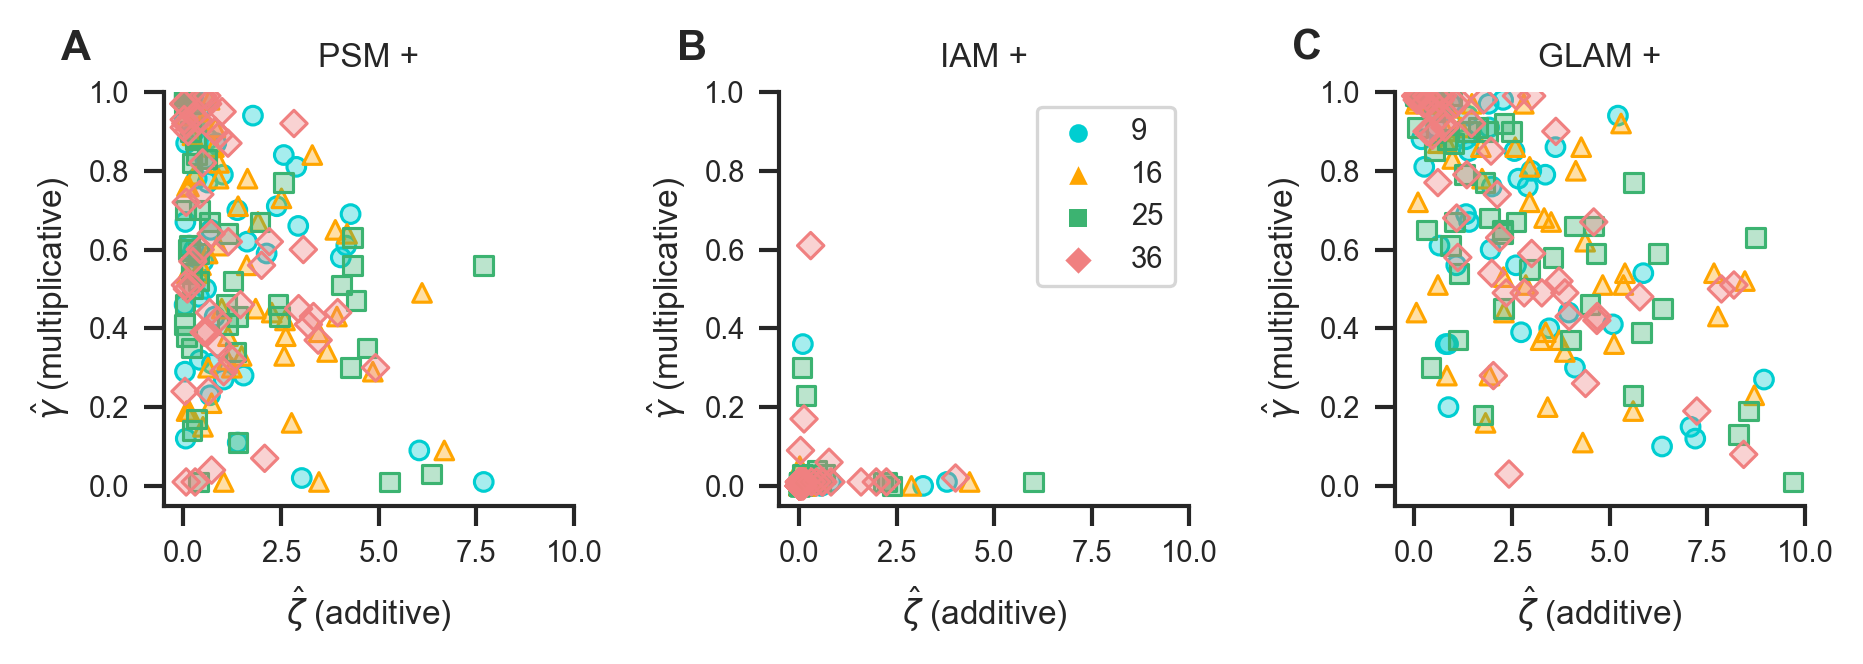

In [5]:
np.random.seed(15124)
seed = 15124

fig, axs = plt.subplots(1,3,figsize=cm2inch(16,6), dpi=300)

# iterate models
for i, (model_name, model_title) in enumerate(zip(model_names, model_titles)):  
    print('\nProcessing: {}+'.format(model_title))
    
    # iterate set sizes
    mfx_data = []
    for si, setsize in enumerate(setsizes):
        # extract gaze bias values
        zeta_vals = estimates['{}_{}'.format(model_name, 'with_active_gaze')][setsize]['zeta']
        gamma_vals = estimates['{}_{}'.format(model_name, 'with_active_gaze')][setsize]['gamma']
        # plot scatters
        _scatter(zeta_vals, gamma_vals, axs[i], 
                 label=setsize, marker=markers[si], color=colors[si])
        # collect estimates
        mfx_data.append(pd.DataFrame({'zeta': zeta_vals,
                                      'gamma': gamma_vals,
                                      'setsize': setsize}))
        
    # compute mfx model: gamma ~ zeta
    mfx_data = pd.concat(mfx_data)
    mfx_filename = '{}-gamma_{}-zeta'.format(model_name, model_name)
    if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
        converged = False
        tries = 1
        while not converged:
            # make model
            samples = 2000
            burn = 500
            model = bambi.Model(data=mfx_data)
            model.add('gamma ~ zeta',
                      random=['1+zeta|setsize'],
                      categorical=['setsize'])
            # sample posterior
            results = model.fit(samples=samples,
                                tune=burn*tries,
                                chains=2,
                                backend='pymc',
                                init='ADVI',
                                n_init=50000,
                                random_seed=seed)
            # save results
            pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
            az.plot_trace(results)
            plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
            summary = az.summary(results, round_to='none')
            summary.to_csv(mfx_dir+mfx_filename+'.csv')
            # check convergence
            if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
               (np.abs(summary.loc['zeta[0]', 'r_hat'] - 1) <= 0.05):
                converged = True
            tries += 1
    else:
        print('Loading mfx-summary from '+mfx_dir)
        summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
    b0,hdi0 = get_var(summary, 'Intercept[0]')
    b1,hdi1 = get_var(summary, 'zeta[0]')
    
    # plotting settings
    axs[i].set_ylim(-0.05, 1)
    axs[i].set_xlim(-0.5, 10)
    axs[i].set_xticks([0, 2.5, 5, 7.5, 10])
    # label axes
    axs[i].set_title(model_title+' +', fontsize=8)
    axs[i].set_xlabel(r'$\hat{\zeta}$'+' (additive)', fontsize=8)
    axs[i].set_ylabel(r'$\hat{\gamma}$'+' (multiplicative)', fontsize=8)
    # further plotting setti0ngs
    despine(ax=axs[i])
    axs[i].tick_params(axis='both', which='major', labelsize=7)

# label axes
for ax, label in zip(axs.ravel(), list('ABC')):
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.text(-0.25, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    despine(ax=ax)

    # add legend
leg = axs[1].legend(loc='upper right', fontsize=7)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# save
fig.tight_layout()
fig.savefig(figure_dir+'Figure-7_association-gaze-biases.pdf', dpi=300)
fig.savefig(figure_dir+'Figure-7_association-gaze-biases.png', dpi=300)
fig.savefig(figure_dir+'Figure-7_association-gaze-biases.jpg', dpi=300)